In [1]:
import pandas as pd
import numpy as np
import duckdb # библиотека для работы с SQL

In [2]:
item = pd.read_csv('item.csv')
sessions_closed = pd.read_csv('sessions_closed.csv')

#### Чтобы вычислить качество выполнения задания можно использовать простую формулу
Количество успешно выполненных заданий / Общее количество заданий, исключая при этом Status = 100
- Я исключил Status = 100, так как коррдинатор в большинстве случаев очень быстро отклоняет задание и задание нельзя считать неуспешным
- Если Status = 102, то задание однозначено выполнено неуспешно
- Если Status = 101, этот статус обсуждаем. Я буду учитывать этот статус при оценке качества. Задание также было выполнено неуспешно, т.к. пользователь сам отказался от выполнения.
- Если Status = 103, то это успех

Вторым вариантом можно было присвоить веса каждому статусу, но я выберу первую модель

In [3]:
item = item.rename(columns={'id':'task_id'})

In [4]:
# объединю две таблицы
df = pd.merge(sessions_closed, item, how='left', on='task_id')

In [5]:
# дубликатов нет
df.duplicated().sum()

0

In [6]:
# пропущенных значений нет, с типами данных тоже всё впорядке. (Даты нам не нужны)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748123 entries, 0 to 748122
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          748123 non-null  int64  
 1   task_id     748123 non-null  int64  
 2   user_id     748123 non-null  int64  
 3   status      748123 non-null  int64  
 4   created_at  748123 non-null  object 
 5   updated_at  748123 non-null  object 
 6   type_id     748123 non-null  int64  
 7   name        748123 non-null  object 
 8   points      748123 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 51.4+ MB


#### Момент с определением списка заданий. 
У многих заданий которые называются одинаково, разные task_id. Если мы будет группировать и агрегировать по task_id, получится 58866 различных значений. Кажется это слишком много и будет более правильно, если группы будут меньше.

Также можно группировать по type_id, будет всего 4 значения, но это будут слишком общие данные

Поэтому группирую по name, получится 285 значений

In [7]:
df['task_id'].nunique()

58866

In [8]:
df['name'].nunique()

285

In [9]:
# распределение по type_id
df['type_id'].value_counts()

type_id
3    466992
2    247242
4     32690
5      1199
Name: count, dtype: int64

In [10]:
# пример ДФ с одинаковым name и разными task_id
df.loc[df['name'] == 'Фиксация состояния объекта городского хозяйства']

,id,task_id,user_id,status,created_at,updated_at,type_id,name,points
241782,727263,21062,7369,100,2022-09-19 17:03:23,2022-09-19 17:03:43,2,Фиксация состояния объекта городского хозяйства,470.0
241786,727275,20995,37542,103,2022-09-19 17:08:04,2022-09-20 12:42:21,2,Фиксация состояния объекта городского хозяйства,390.0
241787,727278,20995,37574,103,2022-09-19 17:08:30,2022-09-20 12:43:20,2,Фиксация состояния объекта городского хозяйства,390.0
241788,727281,21048,1238,103,2022-09-19 17:08:53,2022-09-20 12:57:36,2,Фиксация состояния объекта городского хозяйства,470.0
241789,727284,21064,14645,100,2022-09-19 17:09:05,2022-09-19 19:54:28,2,Фиксация состояния объекта городского хозяйства,470.0
...,...,...,...,...,...,...,...,...,...
746593,1826286,51317,6774,102,2023-04-16 15:21:40,2023-04-16 19:22:01,2,Фиксация состояния объекта городского хозяйства,390.0
746598,1826338,51353,710,100,2023-04-16 16:50:52,2023-04-16 16:50:58,2,Фиксация состояния объекта городского хозяйства,700.0
746599,1826346,51413,121167,102,2023-04-16 17:01:31,2023-04-16 21:02:01,2,Фиксация состояния объекта городского хозяйства,470.0
746601,1826364,51316,122640,102,2023-04-16 17:24:12,2023-04-16 21:25:01,2,Фиксация состояния объекта городского хозяйства,700.0


In [11]:
# распределение по статусам. В целом очень много успешных выполнений.
df['status'].value_counts()

status
103    636990
102     67780
100     42534
101       819
Name: count, dtype: int64

In [12]:
# количество успещных выполненных заданий
df_success = df.loc[df['status'] == 103].groupby('name', as_index=False).agg({'status':'count'}) \
.rename(columns={'status':'count_success'})

In [13]:
# общее количество заданий
df_all = df.loc[df['status'] != 100].groupby('name', as_index=False).agg({'status':'count'}) \
.rename(columns={'status':'count_all'})

In [14]:
df_group = pd.merge(df_success, df_all, how='inner', on='name')

In [15]:
# рассчитаю качество выполнения
df_group['success_rate'] = round(df_group['count_success'] / df_group['count_all'], 2)

In [16]:
df_group.sort_values('success_rate', ascending=False).head(5)

,name,count_success,count_all,success_rate
67,Мониторинг содержания контейнерных площадок,187673,187673,1.0
230,Фиксация содержания бортового камня,1490,1490,1.0
149,Пройдите игру и ознакомьтесь с сервисом «Перее...,1,1,1.0
160,Прохождение профтестирования,27,27,1.0
167,Рассказ о любимом парке «Покровский берег»,4,4,1.0


Возникает небольшая проблемка с высоким success_rate для малого количества значений (строка 149, 167 и т.д.)

Чтобы нейтрализовать этот эффект, при раcсчете success_rate добавлю в числитель и знаменатель + 1, согласно формуле
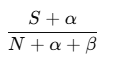

In [17]:
# рассчитаю качество выполнения
alpha = 1
beta = 1
df_group['success_rate2.0'] = round((df_group['count_success'] + alpha) / (df_group['count_all'] + alpha + beta), 2)

In [18]:
# эффект влияния малого количества заданий уменьшен
df_group.sort_values('success_rate2.0', ascending=False).head(5)

,name,count_success,count_all,success_rate,success_rate2.0
67,Мониторинг содержания контейнерных площадок,187673,187673,1.0,1.0
230,Фиксация содержания бортового камня,1490,1490,1.0,1.0
66,Марафон заданий,1199,1199,1.0,1.0
18,Детекция объектов,28122,28122,1.0,1.0
229,Фиксация содержания асфальтобетонного покрытия,1463,1463,1.0,1.0


In [19]:
df_result = df_group[['name', 'success_rate2.0']].sort_values('success_rate2.0', ascending=False)

In [20]:
df_result

,name,success_rate2.0
67,Мониторинг содержания контейнерных площадок,1.00
230,Фиксация содержания бортового камня,1.00
66,Марафон заданий,1.00
18,Детекция объектов,1.00
229,Фиксация содержания асфальтобетонного покрытия,1.00
...,...,...
79,Новые адреса счастья,0.16
109,Популяризация программы «Пушкинская карта»,0.14
246,Фотосъемка для участия в акции «Мой двор» прое...,0.13
126,Посетите экскурсию по скейт-парку и школе экст...,0.12


In [21]:
df_result.to_csv('task_02_result.csv')